# Chord DHT Analysis

This notebook contains an analysis of a custom implementation of the Chord Distributed Hash Table (DHT) protocol. The Chord protocol is a scalable and distributed lookup protocol that can be used to locate the node responsible for a given key in a distributed system. The protocol is used in many peer-to-peer (P2P) systems to implement distributed hash tables.

- *Join:* joining a new node to the ring.
- *Leave:* removing a node from the ring.
- *Insert:* inserting a new key-value pair in the ring.
- *Lookup:* searching for a key in the ring.

## Load Test Data

We will use a dataset of computer scientists (scrapped from Wikipedia) to test the various operations of the Chord DHT implementation. The dataset contains the following columns:

- `name`: the last name of the scientist.
- `education`: the institution where the scientist received their first degree.
- `awards`: the number of awards received by the scientist.

In [57]:
import ast

import pandas as pd

df = pd.read_csv('../data/computer_scientists.pp.csv')

# Keep only the last names, the first education and the number of awards of each scientist.
df['name'] = df['name'].apply(lambda x: x.split(' ')[-1])
df['education'] = df['education'].apply(ast.literal_eval).apply(lambda x: x[0] if x else None)
df['awards'] = df['awards'].apply(ast.literal_eval).apply(lambda x: len(x))

# Drop all rows with missing values in the education column.
df = df.dropna(subset=["education"], ignore_index=True)

df

,name,education,awards
0,Khan,University of Malaya,0
1,Aaronson,Cornell University,4
2,Abebe,Cornell University,0
3,Abelson,Princeton University,1
4,Abiteboul,University of Southern California,6
...,...,...,...
523,Zedan,University of Bristol,0
524,Zilberstein,"University of California, Berkeley",0
525,Zimmerman,Purdue University,0
526,Zuckerberg,Harvard University,0


## Benchmarking

For the benchmarking, we will measure the time taken to perform each of the aforementioned operations for different sizes of the Chord ring.

In [58]:
from src.chord_dht.chord import Chord
import logging
import timeit

logging.disable()

M = range(1, 9)

chords = {m: Chord(m) for m in M}
op_df = pd.DataFrame(index=M)
op_df.index.name = 'M'

### Join

The join operation consists of adding a new node to the Chord ring. In this case, we will join the node with the highest ID in the ring, which will require the node to update its finger table and the finger tables of other nodes in the ring.

In [59]:
for m, chord in chords.items():
    t_sum = 0
    for i in range(2 ** m):
        t1 = timeit.default_timer()
        chord.join(i)
        t2 = timeit.default_timer()
        t_sum += (t2 - t1) * 1000_000

    op_df.loc[m, 'join'] = t_sum / (2 ** m)

### Leave

The leave operation consists of removing a node from the Chord ring. In this case, we will remove the node with the highest ID in the ring, which will require the node to update its finger table and the finger tables of other nodes in the ring.

In [60]:
for m, chord in chords.items():
    t_sum = 0
    for i in range(2 ** m // 2):
        t1 = timeit.default_timer()
        chord.leave(i * 2)
        t2 = timeit.default_timer()
        t_sum += (t2 - t1) * 1000_000

    op_df.loc[m, 'leave'] = t_sum / (2 ** m // 2)

### Insertion

The insertion operation consists of adding a new key-value pair to the Chord ring. In this case, we will insert the key with the highest ID in the ring, which will require the node to traverse its finger table to find the responsible node for the key and update its finger table and the finger tables of other nodes in the ring.

In [61]:
for m, chord in chords.items():
    t_sum = 0
    for _, row in df.iterrows():
        t1 = timeit.default_timer()
        chord.insert(row['education'], {'name': row['name'], 'awards': row['awards']})
        t2 = timeit.default_timer()
        t_sum += (t2 - t1) * 1000_000

    op_df.loc[m, 'insert'] = t_sum / len(df)

### Lookup

The lookup operation consists of searching for a key in the Chord ring. In this case, we will search for the key with the highest ID in the ring, which will require the node to traverse its finger table to find the responsible node for the key.

In [62]:
for m, chord in chords.items():
    t_sum = 0
    for _, row in df.iterrows():
        t1 = timeit.default_timer()
        chord.lookup(row['education'])
        t2 = timeit.default_timer()
        t_sum += (t2 - t1) * 1000_000

    op_df.loc[m, 'lookup'] = t_sum / len(df)

### Results

The following table shows the average time taken to perform each operation for different sizes of the Chord ring. We will plot the results to visualize the performance of the Chord DHT implementation.

In [73]:
op_df = op_df.round(2)
op_df.to_csv('../report/chord_dht_analysis.csv')

op_df

,join,leave,insert,lookup
M,,,,
1,23.50,32.10,22.09,19.42
2,13.52,25.45,18.83,20.79
3,53.81,15.05,19.54,22.97
4,120.71,21.84,22.93,23.45
5,156.49,35.70,24.58,25.45
6,926.11,46.32,23.73,27.42
7,2314.75,76.17,32.81,27.94
8,7468.81,152.85,31.17,42.41


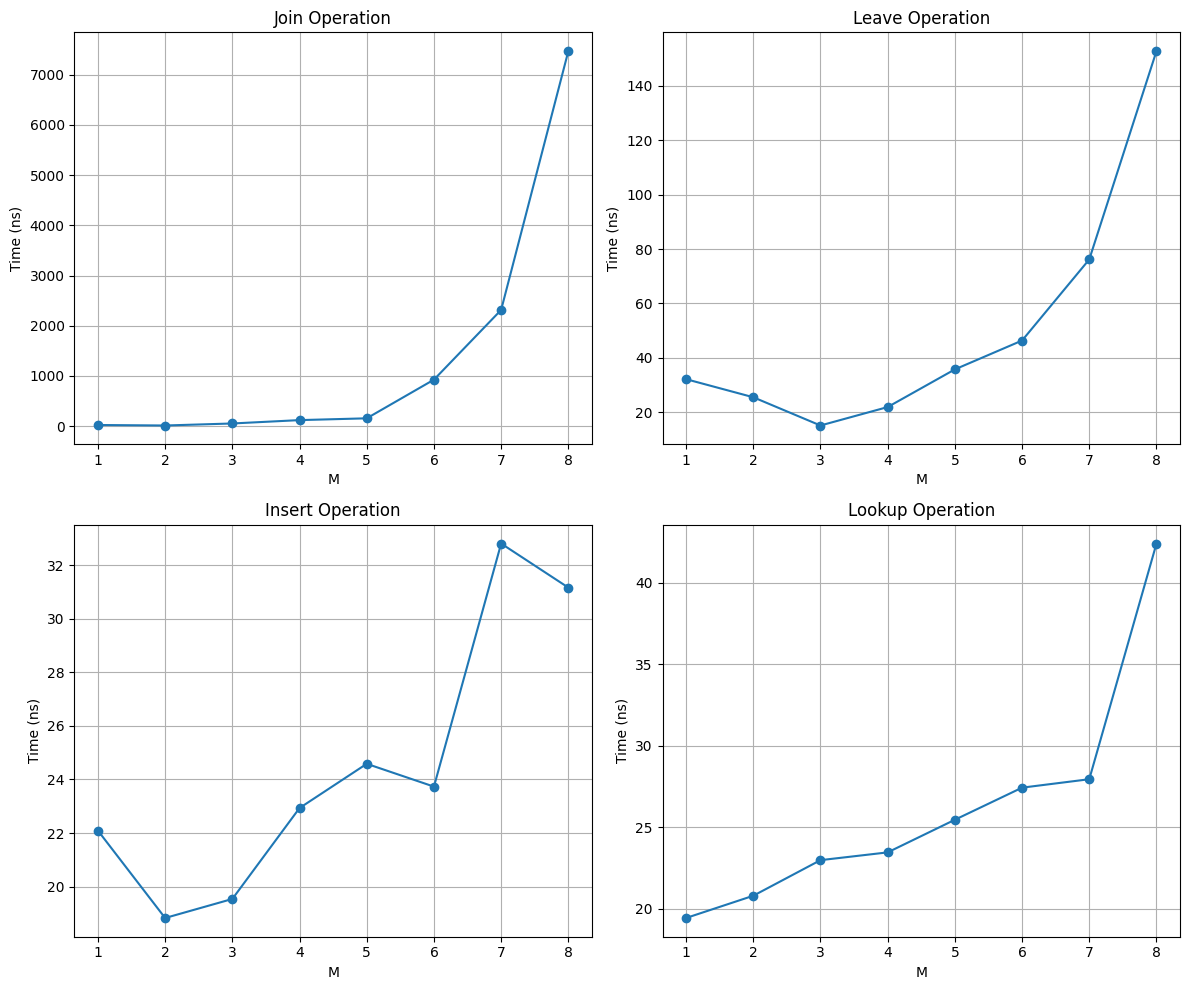

In [70]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

operations = ['join', 'leave', 'insert', 'lookup']

for ax, op in zip(axs.flatten(), operations):
    op_df[op].plot(kind='line', marker='o', ax=ax)
    ax.set_title(f'{op.capitalize()} Operation')
    ax.set_xlabel('M')
    ax.set_ylabel('Time (ns)')
    ax.grid(True)

plt.tight_layout()
plt.savefig('../report/chord_dht_analysis.png')
plt.show()

<Figure size 640x480 with 0 Axes>